<a href="https://colab.research.google.com/github/shivendr7/ml/blob/assignments/SubpixelConv2D_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

250249216/250242400 [==============================] - 75s 0us/step


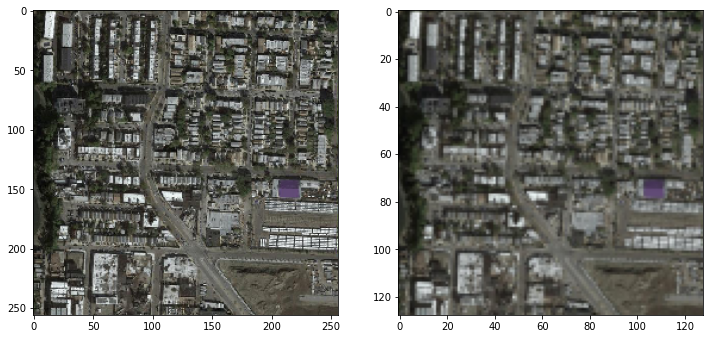

In [1]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Reshape, Flatten, Lambda, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import tensorflow as tf
#from keras.losses import MeanSquaredError

In [5]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [9]:
inp=Input(shape=(128,128,3))
conv1=Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', kernel_initializer='Orthogonal')(inp)
conv1=Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='Orthogonal')(conv1)
conv1=Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='Orthogonal')(conv1)
conv1=Conv2D(12, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='Orthogonal')(conv1)
out=SubpixelConv2D(conv1.shape, scale=2)(conv1)
model=Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mse')

In [12]:
n_batch=5
for i in range(100):
  ix=np.random.randint(0, 1095, n_batch)
  x_train=resized_list[ix]
  y_train=src_list[ix]
  loss= model.train_on_batch(x_train, y_train)
  print('loss', loss)

loss 2571.55029296875
loss 3555.08251953125
loss 1873.992919921875
loss 1444.9351806640625
loss 658.2141723632812
loss 1229.1370849609375
loss 1317.0970458984375
loss 1326.367431640625
loss 1179.7308349609375
loss 1258.783203125
loss 1137.915771484375
loss 1038.832275390625
loss 458.3785095214844
loss 611.6973266601562
loss 909.9495849609375
loss 544.4421997070312
loss 981.7488403320312
loss 656.70556640625
loss 717.5037841796875
loss 474.53240966796875
loss 705.83984375
loss 395.9712219238281
loss 500.04541015625
loss 589.3015747070312
loss 525.1258544921875
loss 505.06439208984375
loss 599.883056640625
loss 330.36651611328125
loss 581.2611083984375
loss 421.76055908203125
loss 430.669677734375
loss 794.7379760742188
loss 552.981201171875
loss 686.114990234375
loss 434.46978759765625
loss 483.92401123046875
loss 401.8967590332031
loss 353.29248046875
loss 643.6521606445312
loss 424.2964782714844
loss 401.1480712890625
loss 511.39410400390625
loss 596.8727416992188
loss 421.01528930664

In [14]:
out=model.predict(resized_list[:5])

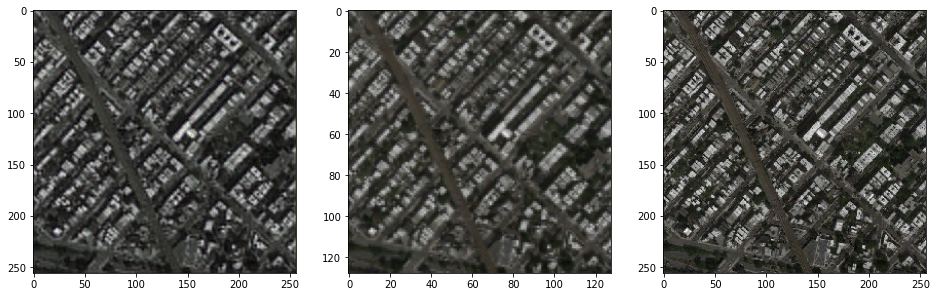

In [17]:
i=2
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(out[i].reshape(256,256,3).astype('uint8'))
plt.subplot(1,3,2)
plt.imshow(resized_list[i].reshape(128,128,3).astype('uint8'))
plt.subplot(1,3,3)
plt.imshow(src_list[i].reshape(256,256,3).astype('uint8'))
#left predicted SR   mid input LR   right stored HR